Welcome to one of the collaborative Jupyter/Spark environments in ZHAW. You are not yet connected to Sparky by default. However, the necessary code template makes this a quick process. Keep in mind that you are sharing both the Jupyter environment and the Sparky cluster with others. Custom Python packages on the notebook/Spark driver side are installed with %pip install.

In [1]:
zhawaccount = "hasslrob"  # TODO set this to your ZHAW-Kürzel

In [2]:
import sparky
import pyspark
#import slash
import pyspark.sql
sc = sparky.connect(f"sparknotebook-{zhawaccount}", 2)
spark = pyspark.sql.SparkSession.builder.getOrCreate()

~~~ Sparky module loaded ~~~


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/26 18:10:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/26 18:10:22 WARN Utils: Service 'sparkDriver' could not bind on port 5555. Attempting port 5556.
24/06/26 18:10:23 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 4444. Attempting port 4445.


Attached to Sparky cluster context from sparky-collab as sparknotebook-hasslrob.
Requested 2 cores; real number might be less.


In [3]:
import time

In [4]:
# Read csv-files
read_time = time.time()
df_customer = spark.read.format("csv").option("header", "true").load("Customermaster.csv")
df_items = spark.read.format("csv").option("header", "true").load("Itemmaster.csv")
df_orders = spark.read.format("csv").option("header", "true").load("Orderlines.csv")
df_currate = spark.read.format("csv").option("header", "true").load("ExchangeRates.csv")
read_time_finish = time.time()
print(f"Time taken to read: {read_time_finish - read_time:.2f} seconds")

Time taken to read: 6.19 seconds


In [5]:
# Clean Data
from pyspark.sql.functions import trim, col, to_date, when

# Customer ---------------------------
df_customer = df_customer.withColumn("Status", col("Status").cast("integer"))
df_customer = df_customer.withColumn("Potential", col("Potential").cast("float"))
df_customer = df_customer.withColumn("Entry Date", to_date(col("Entry Date"), "yyyyMMdd"))

# Item ---------------------------
df_items = df_items.withColumn("Item number", trim(df_items["Item number"]))
df_items = df_items.withColumn("Itemgroup", trim(df_items["Itemgroup"]))
df_items = df_items.withColumn("Itemgroup", col("Itemgroup").cast("integer"))
df_items = df_items.withColumn("Productgroup", trim(df_items["Productgroup"]))
df_items = df_items.withColumn("Itemtype", trim(df_items["Itemtype"]))

# Define mapping dictionary for renaming
rename_map = {
    "1000": "Valve",
    "1100": "Actuator",
    "1200": "Fitting",
    "1300": "Instrumentation",
    "1400": "Air Line Equipment",
    "1500": "Vacuum Unit",
    "1600": "Heat Exchanger",
    "1700": "Hydraulics",
    "1800": "Filter",
    "1900": "Other",
    "": "Other",
    "2000": "3rdParty"
}

# Rename values in the "Itemgroup" column based on the mapping dictionary
#df_items = df_items.withColumn("Itemgroup", 
#                    when(col("Itemgroup").isin(list(rename_map.keys())), 
#                         rename_map[col("Itemgroup")]).otherwise(col("Itemgroup")))

# Order ---------------------------
df_orders = df_orders.withColumn("Customernumber", trim(df_orders["Customernumber"]))
df_orders = df_orders.withColumn("Item number", trim(df_orders["Item number"]))
df_orders = df_orders.withColumn("Status", col("Status").cast("integer"))
df_orders = df_orders.withColumn("Net price", col("Net price").cast("float"))

quantity_columns = [
    "Ordered quantity", "Confirmed quantity", "Remaining quantity", 
    "Allocated quantity", "Picking list quantity", 
    "Delivered quantity", "Invoiced quantity"
]

for column in quantity_columns:
    df_orders = df_orders.withColumn(column, col(column).cast("integer"))
    
date_columns = [
    "Requested delivery date", "Confirmed delivery date", 
    "Departure date", "Planning date", "Registration date"
]

for column in date_columns:
    df_orders = df_orders.withColumn(column, to_date(col(column), "yyyyMMdd"))

# Exchange Rate ---------------------------
df_currate = df_currate.withColumn("ExchangeRate", col("ExchangeRate").cast("float"))
df_currate = df_currate.withColumn("ActiveDate", to_date(col("ActiveDate"), "yyyyMMdd"))

In [ ]:
# Store the files in Parquet format 
df_customer.write.mode("overwrite").parquet("./customermaster.parquet")
df_items.write.mode("overwrite").parquet("./itemmaster.parquet")
df_orders.write.mode("overwrite").parquet("./orderlines.parquet")
df_currate.write.mode("overwrite").parquet("./exchangerates.parquet")

In [6]:
# Read parquet-files
read_time_start = time.time()
df_customer_p = spark.read.parquet("./customermaster.parquet", header=True, inferSchema=True)
df_items_p = spark.read.parquet("./itemmaster.parquet", header=True, inferSchema=True)
df_orders_p = spark.read.parquet("./orderlines.parquet", header=True, inferSchema=True)
df_currate_p = spark.read.parquet("./exchangerates.parquet", header=True, inferSchema=True)
read_time_finish = time.time()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")

Time taken to read: 1.24 seconds


In [7]:
# Return the number of records per file.
record_count = df_customer_p.count()
print(f"Number of records in customer: {record_count}\n")
record_count = df_items_p.count()
print(f"Number of records in items: {record_count}\n")
record_count = df_orders_p.count()
print(f"Number of records in orders: {record_count}\n")

Number of records in customer: 39250

Number of records in items: 2226456

Number of records in orders: 465209



In [8]:
df_customer_p.head()

Row(Customernumber='K072870000', Status=10, CGC='XXX', Industry='M', Potential=2000.0, DiscountModel='SMCSTDCHFA', PriceList='STDPRICE  ', Currency='CHF', TargetFlag=' ', IndirectFlag=' ', Oldcustomernr='          ', Newcustomernr='K01286JIT0', Incoterms='EXW', CRMflag='5', CRMID='6dcfddfa-1c83-11ee-98f4-0050568cbcf8', SPC='KM03', Entry Date=datetime.date(2023, 7, 6))

In [9]:
df_items_p.head()

Row(Item number='02419283', Status='20', Itemgroup=1900, Productgroup='999', Itemtype='2', EntryDate='20220412', Responsible='LOCAL ES  ')

In [ ]:
df_orders_p.head()

In [ ]:
df_currate_p.tail(5)

In [10]:
df_customer_p.createOrReplaceTempView("customer")
df_items_p.createOrReplaceTempView("items")
df_orders_p.createOrReplaceTempView("orders")
df_currate_p.createOrReplaceTempView("exchangerate")
df_customer.createOrReplaceTempView("customerCSV")
df_items.createOrReplaceTempView("itemsCSV")
df_orders.createOrReplaceTempView("ordersCSV")
df_currate.createOrReplaceTempView("exchangerateCSV")

In [11]:
# Count unique sold Items - does not work?
read_time_start = time.time()
result = spark.sql("""Select Count(Distinct `Item number`) as UniqueItems From orders""")
read_time_finish = time.time()
result.show()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")


+-----------+
|UniqueItems|
+-----------+
|      39231|
+-----------+

Time taken to read: 0.10 seconds


In [19]:
# RDD from DF
orders_rdd = df_orders_p.rdd

read_time_start = time.time()
# Map-Transformation, to create RDD with Itemnumber
item_numbers_rdd = orders_rdd.map(lambda row: row['Item number'])

# Count unique Itemnr
unique_items_count = item_numbers_rdd.distinct().count()
read_time_finish = time.time()

print(f"Unique Items: {unique_items_count}")
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")


Unique Items: 39231
Time taken to read: 2.34 seconds


In [20]:
# Count Orderlines in CHF in 2020 in CHF
read_time_start = time.time()
result = spark.sql("""
SELECT
    Count(or.`Customernumber`) as CountOrderLines
FROM 
    orders as or
LEFT JOIN 
    customer as cu
ON
    or.Customernumber = cu.Customernumber
WHERE
    cu.Currency = 'CHF' AND
    or.Status > 5 and or.Status < 90 AND
    or.`Registration date` BETWEEN '2020-01-01' AND '2020-12-31'
""")
read_time_finish = time.time()
result.show()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")

+---------------+
|CountOrderLines|
+---------------+
|         102338|
+---------------+

Time taken to read: 0.02 seconds


In [13]:
# Overall Orderamount in 2021 with CHF-Customers
read_time_start = time.time()
result = spark.sql("""
SELECT
    SUM(`Ordered quantity` * `Net price`)/1000000 as MioOrderAmountCHF
FROM 
    orders as or
LEFT JOIN 
    customer as cu
ON
    or.Customernumber = cu.Customernumber
WHERE
    cu.Currency = 'CHF' AND
    or.Status > 5 AND or.Status < 90 AND
    or.`Registration date` BETWEEN '2020-01-01' AND '2020-12-31' """)
read_time_finish = time.time()
result.show()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")

+------------------+
| MioOrderAmountCHF|
+------------------+
|19.785846694221533|
+------------------+

Time taken to read: 0.04 seconds


In [21]:
# Select only latest Exchange-Rates due to ranking
read_time_start = time.time()
result = spark.sql("""
Select *, 
dense_rank() over (Partition by ForeignCurrency Order By ActiveDate desc) as rankno
From exchangerate
where ForeignCurrency != 'CHF' """)
read_time_finish = time.time()
result.show()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")

+----------+-------------+---------------+------------+------+
|ActiveDate|LocalCurrency|ForeignCurrency|ExchangeRate|rankno|
+----------+-------------+---------------+------------+------+
|2021-07-29|          CHF|            CZK|    0.043715|     1|
|2022-05-31|          CHF|            DKK|     0.13163|     1|
|2022-04-30|          CHF|            DKK|    0.131223|     2|
|2022-03-31|          CHF|            DKK|    0.130946|     3|
|2022-03-31|          CHF|            DKK|    0.130219|     3|
|2022-01-31|          CHF|            DKK|    0.125392|     4|
|2021-12-31|          CHF|            DKK|    0.124247|     5|
|2021-11-30|          CHF|            DKK|    0.128267|     6|
|2021-10-31|          CHF|            DKK|    0.128699|     7|
|2021-09-30|          CHF|            DKK|    0.129661|     8|
|2021-09-30|          CHF|            DKK|    0.130219|     8|
|2021-08-31|          CHF|            DKK|    0.128605|     9|
|2021-07-31|          CHF|            DKK|    0.129064|

In [22]:
# Overall Orderamount in 2021 with all-Customers and latest Exchange Rate
read_time_start = time.time()
result = spark.sql("""
SELECT
    SUM(or.`Ordered quantity` * or.`Net price` * ra.ExchangeRate)/1000000 as MioOrderAmountCHF
FROM 
    orders as or
LEFT JOIN 
    customer as cu
ON
    or.Customernumber = cu.Customernumber
LEFT JOIN 
    (SELECT * 
        FROM(
        SELECT
            ActiveDate,
            ForeignCurrency,
            ExchangeRate,
            dense_rank() over (Partition by ForeignCurrency Order By ActiveDate desc) as rankno
        From 
            exchangerate) as exchrate
    WHERE 
        exchrate.rankno = 1) as ra
ON
    cu.Currency = ra.ForeignCurrency
WHERE
    or.Status > 5 AND or.Status < 90 AND
    or.`Registration date` BETWEEN '2020-01-01' AND '2020-12-31' """)
read_time_finish = time.time()
result.show()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")

+-----------------+
|MioOrderAmountCHF|
+-----------------+
|38.80278563723785|
+-----------------+

Time taken to read: 0.03 seconds


In [23]:
# Overall Orderamount in 2020 with all-Customers and latest Exchange Rate by Itemgroup
read_time_start = time.time()
result = spark.sql("""
SELECT
    it.`Itemgroup`,
    SUM(or.`Ordered quantity` * or.`Net price` * COALESCE(ra.ExchangeRate, 1)) / 1000000 as MioOrderAmountCHF
FROM 
    orders as or
LEFT JOIN 
    customer as cu
ON
    or.Customernumber = cu.Customernumber
LEFT JOIN 
    (SELECT
        ForeignCurrency,
        ExchangeRate,
        dense_rank() over (Partition by ForeignCurrency Order By ActiveDate desc) as rankno
     FROM 
        exchangerate
    ) AS ra
ON
    cu.Currency = ra.ForeignCurrency AND ra.rankno = 1
LEFT JOIN
    items as it
ON
    or.`Item number` = it.`Item number`
WHERE
    or.Status > 5 AND or.Status < 90 AND
    or.`Registration date` BETWEEN '2020-01-01' AND '2020-12-31'
GROUP BY
    it.`Itemgroup`""")
read_time_finish = time.time()
result.show()
print(f"Time taken to read: {read_time_finish - read_time_start:.2f} seconds")

+---------+--------------------+
|Itemgroup|   MioOrderAmountCHF|
+---------+--------------------+
|     1700|0.016803339213371276|
|     1500|   1.145473103982672|
|     1300|   1.406521786151208|
|     1400|  3.8786443152742645|
|     1100|   7.940280593047347|
|     1800| 0.01856077834749222|
|     1600|  2.2495007827854154|
|     1000|  10.025483562231608|
|     1200|  3.5558132506540856|
|     2000| 0.00560388777923584|
|     1900|    8.56316551486694|
+---------+--------------------+

Time taken to read: 0.03 seconds


### Linediagramm for each Itemgroup per week w/ SQL

In [38]:
import pandas as pd

# SQL query to get data
result = spark.sql("""
SELECT
    YEAR(or.`Registration date`) AS `Year`,
    WEEKOFYEAR(or.`Registration date`) AS `Week`,
    it.`Itemgroup`,
    SUM(or.`Ordered quantity` * or.`Net price` * COALESCE(ra.ExchangeRate, 1)) / 1000000 AS `MioOrderAmountCHF`
FROM 
    orders AS or
LEFT JOIN 
    customer AS cu
ON
    or.Customernumber = cu.Customernumber
LEFT JOIN 
    (SELECT
        ForeignCurrency,
        ExchangeRate,
        DENSE_RANK() OVER (PARTITION BY ForeignCurrency ORDER BY ActiveDate DESC) AS rankno
     FROM 
        exchangerate
    ) AS ra
ON
    cu.Currency = ra.ForeignCurrency AND ra.rankno = 1
LEFT JOIN
    items AS it
ON
    or.`Item number` = it.`Item number`
WHERE
    or.Status > 5 AND or.Status < 90 AND
    or.`Registration date` BETWEEN '2020-01-01' AND '2023-12-31'
GROUP BY
    YEAR(or.`Registration date`),
    WEEKOFYEAR(or.`Registration date`),
    it.`Itemgroup`
""").toPandas()

# Convert 'Year' and 'Week' into a continuous 'Date' field
result['Date'] = pd.to_datetime(result['Year'].astype(str) + '-' + result['Week'].astype(str) + '-1', format='%Y-%W-%w')

# Sort by 'Date'
result = result.sort_values(by='Date')


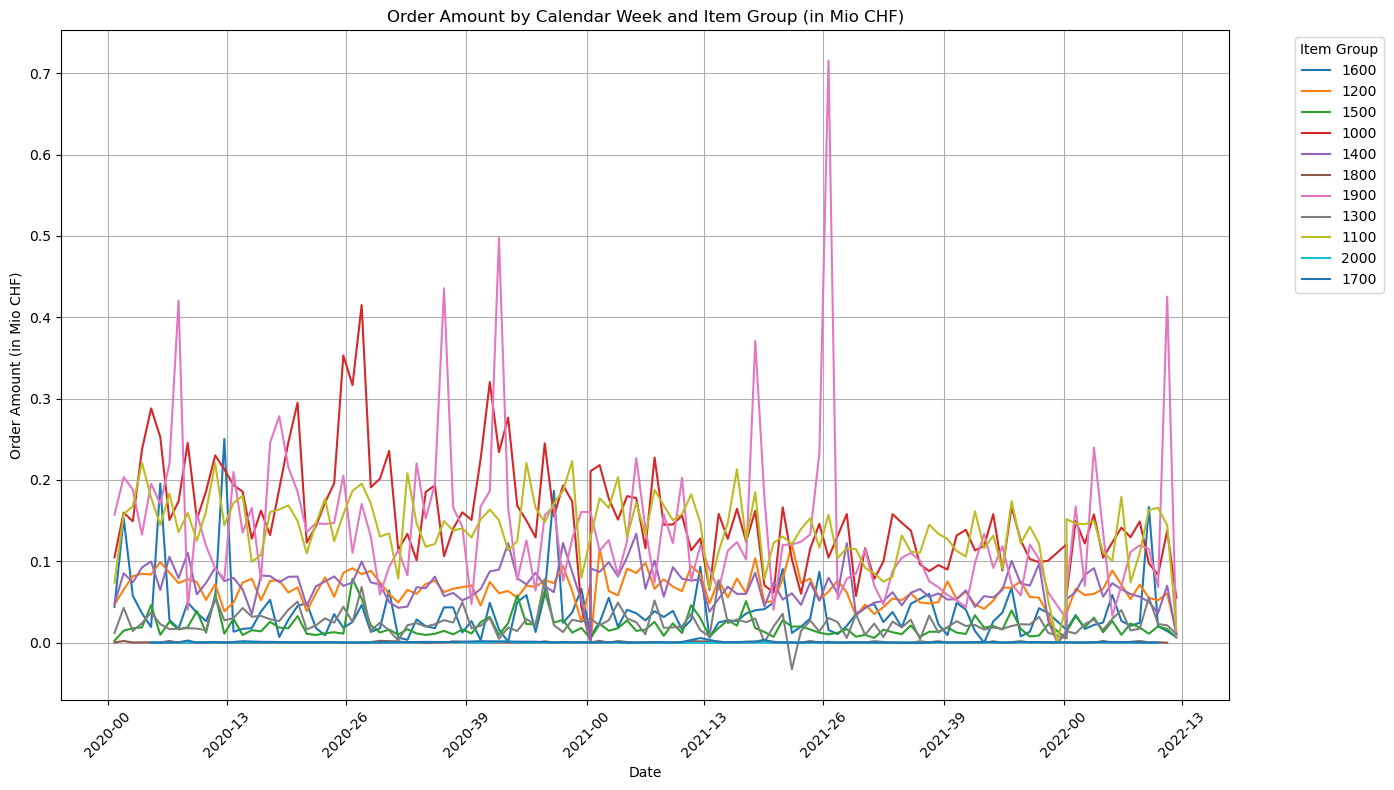

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set up the plot
plt.figure(figsize=(14, 8))

# Iterate over each item group and plot the lines
for itemgroup in result['Itemgroup'].unique():
    group_data = result[result['Itemgroup'] == itemgroup]
    plt.plot(group_data['Date'], group_data['MioOrderAmountCHF'], label=itemgroup)

# Add titles and labels
plt.title('Order Amount by Calendar Week and Item Group (in Mio CHF)')
plt.xlabel('Date')
plt.ylabel('Order Amount (in Mio CHF)')

# Format the x-axis to show the year and week
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatische Datumslocator
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%W'))  # Format als Jahr-Woche

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend(title='Item Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a grid
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Spark optimiert

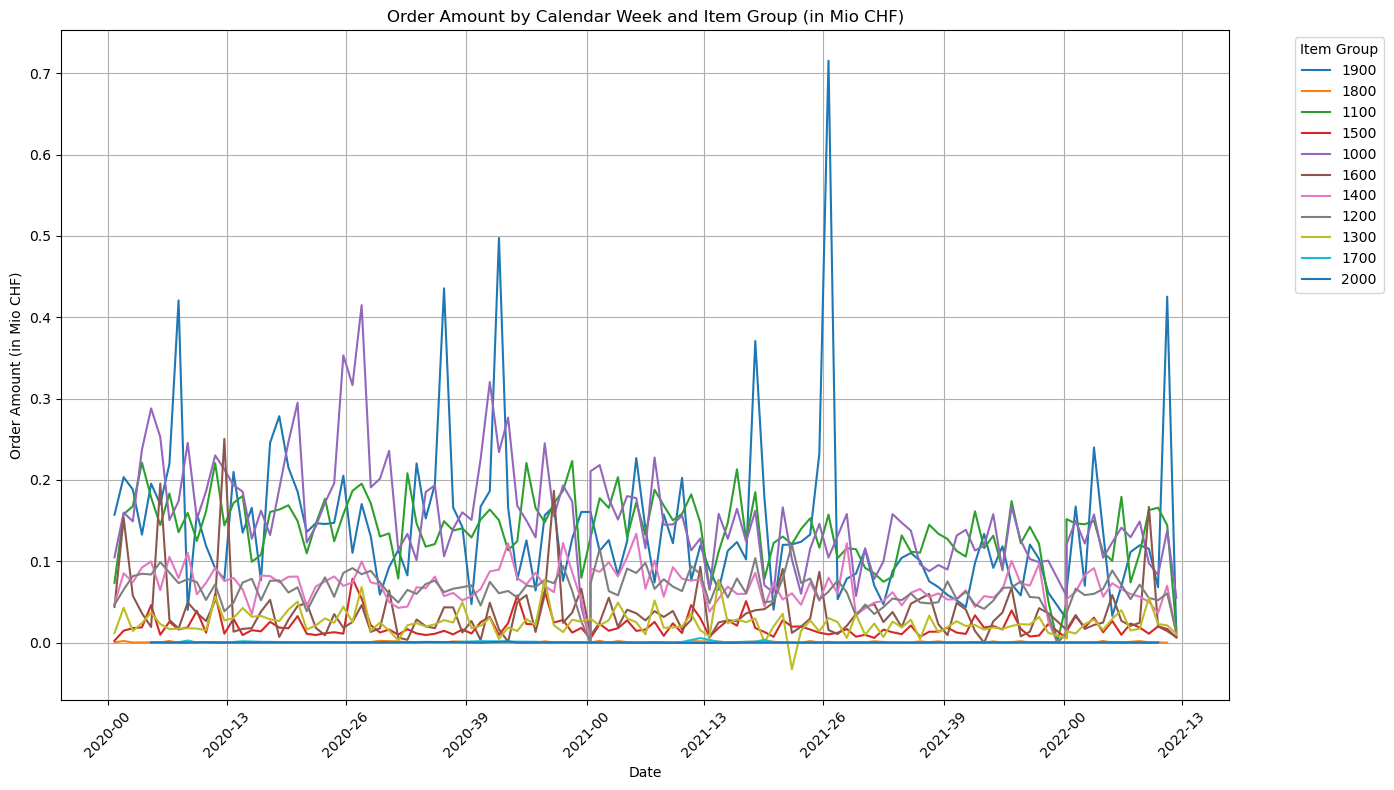

In [45]:
from pyspark.sql import SparkSession, functions as F, Window

# Spark Session erstellen
spark = SparkSession.builder \
    .appName("OrderAmountAnalysis") \
    .getOrCreate()

# Parquet-Dateien lesen
df_customer_p = spark.read.parquet("./customermaster.parquet")
df_items_p = spark.read.parquet("./itemmaster.parquet")
df_orders_p = spark.read.parquet("./orderlines.parquet")
df_currate_p = spark.read.parquet("./exchangerates.parquet")

# Window Specification für die neuesten Wechselkurse
window_spec = Window.partitionBy('ForeignCurrency').orderBy(F.col('ActiveDate').desc())

# Neueste Wechselkurse berechnen
latest_rates = df_currate_p.withColumn('rank', F.dense_rank().over(window_spec)) \
                           .filter(F.col('rank') == 1) \
                           .drop('rank')

# Dataframes verbinden
df_joined = df_orders_p.alias('or') \
    .join(df_customer_p.alias('cu'), F.col('or.Customernumber') == F.col('cu.Customernumber'), 'left') \
    .join(latest_rates.alias('ra'), F.col('cu.Currency') == F.col('ra.ForeignCurrency'), 'left') \
    .join(df_items_p.alias('it'), F.col('or.`Item number`') == F.col('it.`Item number`'), 'left')

# Bestellmenge in CHF berechnen
df_result = df_joined.withColumn('OrderAmountCHF', 
                                 F.col('Ordered quantity') * F.col('Net price') * 
                                 F.coalesce(F.col('ExchangeRate'), F.lit(1)) / 1000000)

# Jahr und Woche extrahieren
df_result = df_result.withColumn('Year', F.year('Registration date')) \
                     .withColumn('Week', F.weekofyear('Registration date'))

# Filtern und gruppieren
df_aggregated = df_result.filter((F.col('or.Status') > 5) & (F.col('or.Status') < 90) &
                                 (F.col('Registration date').between('2020-01-01', '2023-12-31'))) \
                         .groupBy('Year', 'Week', 'Itemgroup') \
                         .agg(F.sum('OrderAmountCHF').alias('MioOrderAmountCHF')) \
                         .orderBy('Year', 'Week')

# Spark DataFrame in Pandas DataFrame konvertieren
result_pandas = df_aggregated.toPandas()

# Spark Session beenden
spark.stop()

# Liniendiagramm erstellen mit Matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Convert 'Year' and 'Week' into a continuous 'Date' field
result_pandas['Date'] = pd.to_datetime(result_pandas['Year'].astype(str) + '-' + result_pandas['Week'].astype(str) + '-1', format='%Y-%W-%w')

# Plot erstellen
plt.figure(figsize=(14, 8))

# Für jede Artikelgruppe eine Linie im Diagramm zeichnen
for itemgroup in result_pandas['Itemgroup'].unique():
    group_data = result_pandas[result_pandas['Itemgroup'] == itemgroup]
    plt.plot(group_data['Date'], group_data['MioOrderAmountCHF'], label=itemgroup)

# Titel und Achsenbeschriftungen hinzufügen
plt.title('Order Amount by Calendar Week and Item Group (in Mio CHF)')
plt.xlabel('Date')
plt.ylabel('Order Amount (in Mio CHF)')

# Formatierung der x-Achse für Jahr und Woche
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatische Datumslocator
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%W'))  # Format als Jahr-Woche

# x-Achsenbeschriftungen drehen, um die Lesbarkeit zu verbessern
plt.xticks(rotation=45)

# Legende hinzufügen
plt.legend(title='Item Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Gitter hinzufügen
plt.grid(True)

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()


In [46]:
sc.stop()